# Purpose

This notebook models and forecasts realised volatility using exponential smoothing methods, and evaluates out-of-sample performance against a naive benchmark.

Exponential smoothing is used as a simple benchmark for modelling persistent volatility dynamics without imposing a parametric structure.

# Load libraries and data

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [60]:
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [62]:
vol_df = pd.read_csv(
    "../data/processed/realised_volatility_21d.csv",
    index_col=0,
    parse_dates=True
)

vol_df.index = pd.to_datetime(vol_df.index, format="%d/%m/%Y", errors="raise")
vol_df = vol_df.sort_index()

vol = vol_df["realised_vol_21d"]

# Train / test split

In [59]:
split_date = "2022-01-01"

train = vol.loc[vol.index < split_date]
test  = vol.loc[vol.index >= split_date]

Training: 2010–2021

Test: 2022–2024

Monthly horizon approximated by 21 trading days

# Baseline volatility model (naive)

In [47]:
naive_forecast = vol.shift(1).loc[test.index]
naive_forecast = naive_forecast.dropna()
test_naive = test.loc[naive_forecast.index]

In [48]:
naive_mae = mean_absolute_error(test_naive, naive_forecast)
naive_rmse = root_mean_squared_error(test_naive, naive_forecast)

naive_mae, naive_rmse

(0.00035137890379233016, 0.0005920194598074877)

# ETS model specification

Volatility has:

* Level, as volatility regimes shift abruptly

* No trend worth trusting, as trends are unstable

* No seasonality worth forcing, as calendar seasonality is weak at daily horizons

In [49]:
ets_model = ExponentialSmoothing(
    train,
    trend=None,
    seasonal=None
)

ets_fit = ets_model.fit()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Out-of-sample forecasting

In [50]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=UserWarning)

    history = train.copy()
    ets_forecasts = []

    for t in range(len(test)):
        model = ExponentialSmoothing(
            history,
            trend=None,
            seasonal=None
        )
        fit = model.fit()
        forecast = fit.forecast(steps=1)
        ets_forecasts.append(forecast.iloc[0])
        history = pd.concat([history, test.iloc[t:t+1]])

An expanding-window approach is used to mirror real-time forecasting, although ETS forecasts are dominated by the most recent observation.

In [51]:
ets_forecasts = pd.Series(
    ets_forecasts,
    index=test.index
)

# ETS diagnostics

In [52]:
residuals = test - ets_forecasts

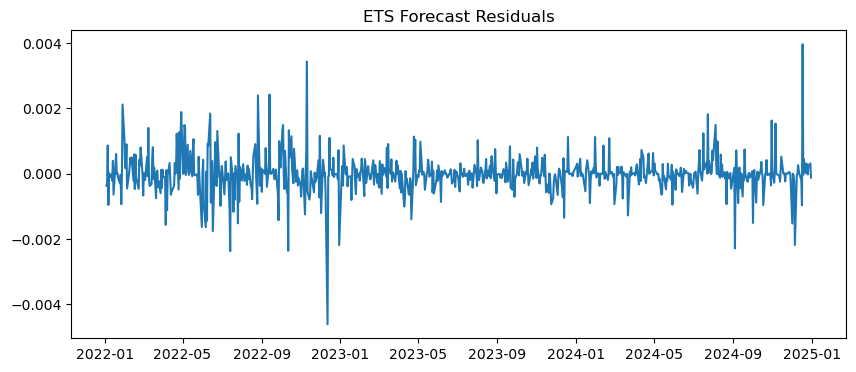

In [53]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("ETS Forecast Residuals")
plt.show()

# Model evaluation

In [54]:
ets_mae = mean_absolute_error(test, ets_forecasts)
ets_rmse = root_mean_squared_error(test, ets_forecasts)

pd.DataFrame({
    "Model": ["Naive Volatility", "ETS"],
    "MAE": [naive_mae, ets_mae],
    "RMSE": [naive_rmse, ets_rmse]
})

,Model,MAE,RMSE
0,Naive Volatility,0.000351,0.000592
1,ETS,0.000351,0.000592


# Forecast visualisation

In [55]:
# Convert list of forecasts to pandas Series with correct index
ets_forecasts = pd.Series(ets_forecasts, index=test.index)

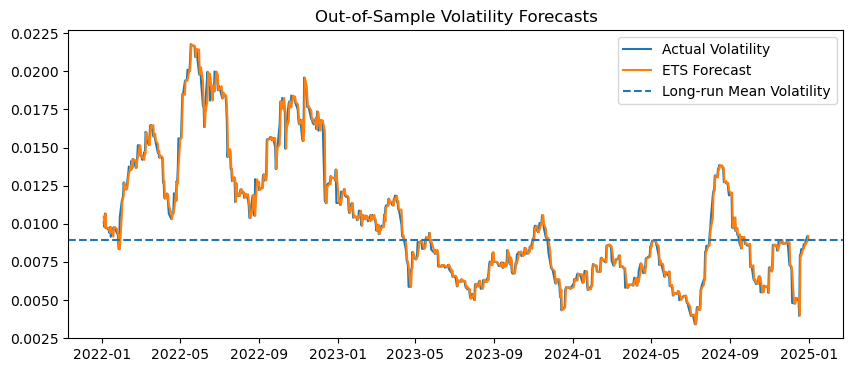

In [56]:
# Long-run mean volatility from training data
long_run_mean = train.mean()

plt.figure(figsize=(10,4))
plt.plot(test.index, test, label="Actual Volatility")
plt.plot(test.index, ets_forecasts, label="ETS Forecast")

plt.axhline(
    y=long_run_mean,
    linestyle="--",
    linewidth=1.5,
    label="Long-run Mean Volatility"
)

plt.legend()
plt.title("Out-of-Sample Volatility Forecasts")
plt.show()

Smooth tracking

Much smaller errors than returns

# Interpretation

At a one-step-ahead horizon, realised volatility is highly persistent, resulting in similar performance between naive and ETS forecasts. 

This highlights the strong memory inherent in volatility processes.

At short horizons, simple persistence-based forecasts are difficult to outperform.

# Save forecasts

In [57]:
ets_forecasts.to_csv("../outputs/forecasts/ets_volatility_forecast.csv")